In [17]:
import numpy as np
import cv2 as cv
import imageio as io
import matplotlib.pyplot as plt
import glob
import os

<ipython-input-33-6764309004ea>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=io.imread("/content/canny1.jpeg")


array([[[243, 172,  92],
        [243, 172,  92],
        [245, 173,  91],
        ...,
        [252, 186, 108],
        [246, 186, 113],
        [233, 180, 114]],

       [[243, 172,  92],
        [243, 172,  92],
        [245, 173,  91],
        ...,
        [252, 186, 108],
        [246, 186, 113],
        [234, 181, 115]],

       [[243, 172,  92],
        [243, 172,  92],
        [245, 173,  91],
        ...,
        [252, 186, 108],
        [246, 186, 113],
        [235, 182, 116]],

       ...,

       [[241, 172,  95],
        [241, 172,  95],
        [241, 172,  95],
        ...,
        [248, 188, 118],
        [244, 189, 122],
        [236, 192, 131]],

       [[242, 169, 100],
        [242, 170,  98],
        [242, 170,  98],
        ...,
        [248, 188, 116],
        [244, 189, 122],
        [236, 192, 131]],

       [[250, 171, 105],
        [248, 169, 103],
        [247, 168, 102],
        ...,
        [251, 193, 119],
        [249, 196, 126],
        [237, 196, 134]]], dtype=uint8)
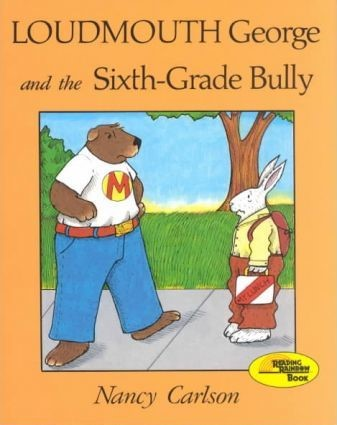

In [33]:
img=io.imread("/content/canny1.jpeg")
img

array([[156, 156, 157, ..., 170, 171, 166],
       [156, 156, 157, ..., 170, 171, 167],
       [156, 156, 157, ..., 170, 171, 168],
       ...,
       [157, 157, 157, ..., 174, 175, 179],
       [157, 157, 157, ..., 173, 175, 179],
       [160, 158, 157, ..., 177, 181, 182]], dtype=uint8)
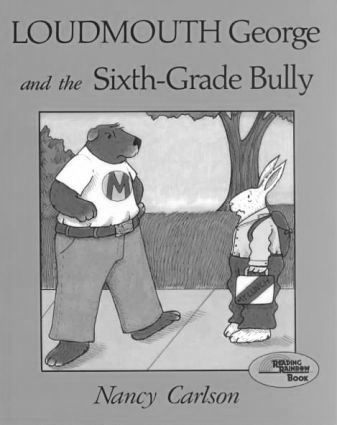

In [19]:
#Canny edge detection
#1. convert to gray scale
def cvtColor(img):
  return cv.cvtColor(img,cv.COLOR_BGR2GRAY)

gray_img=cvtColor(img)
gray_img

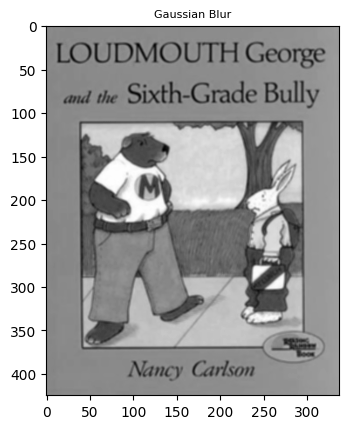

In [20]:
#2. remove noise (gaussian Blur)
rmv_noise_img=cv.GaussianBlur(gray_img,(3,3),1.5)


plt.imshow(rmv_noise_img, cmap='gray')
plt.title('Gaussian Blur',fontsize=8)
plt.show()

In [21]:
#3. Gradient calculation (using sobel,laplacian)

#convulation direct using sobal

sobel_x = cv.Sobel(np.float32(rmv_noise_img), cv.CV_64F, 1, 0, 3) # sobel(img,desire_output_format,1,0,3) 1,0 represent find 1st derivative along x axis, 3 is kernal size
sobel_y= cv.Sobel(np.float32(rmv_noise_img), cv.CV_64F, 0, 1, 3) #0,1 represent the 1st derivative along y- axis
#find megnitude
megnitude=np.sqrt(np.square(sobel_x)+np.square(sobel_y))

#orientation
orientation_radians=np.arctan2(sobel_y,sobel_x)
orientation_degrees=np.degrees(orientation_radians)

#normalize degree into (0-180)
orientation_degrees[orientation_degrees<0]+=180
orientation_degrees[orientation_degrees>180]-=180



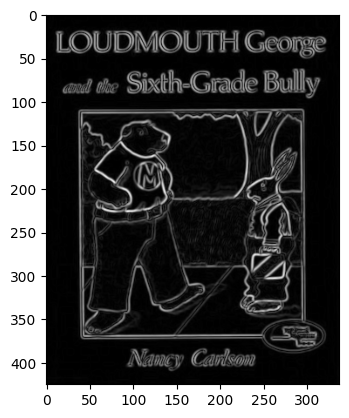

In [22]:

plt.imshow(megnitude,cmap='gray')

In [23]:
orientation_degrees = orientation_degrees.astype(np.float32)
orientation_degrees


array([[  0.      ,   0.      ,   0.      , ..., 180.      , 180.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ..., 171.8699  , 156.8014  ,
         90.      ],
       [  0.      ,   0.      ,   0.      , ..., 168.69006 , 149.03624 ,
         90.      ],
       ...,
       [ 90.      , 123.69007 , 123.69007 , ...,  18.434948,  18.434948,
         90.      ],
       [ 90.      , 135.      , 149.03624 , ...,  18.434948,  18.434948,
         90.      ],
       [  0.      , 180.      , 180.      , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

In [24]:
#step 4 non- maximum- suspression
def return_neighbors(i,j,angle_img): # current pixel,curr angle
  r,c=megnitude.shape
  if((i>=0 and i<=(megnitude.shape[0])-1) and (j>=0 and j<=(megnitude.shape[1]-1))):

    #(0-degree && 180-degree)
    if((0<=angle_img<=22.5 )or(157.5<=angle_img <=180)):
      if(j==megnitude.shape[1]-1): #if in last column
        i1,j1=i,j-1
        i2,j2=i,j
        return i1,j1,i2,j2
      elif(j==0): #if in 1st column
        i1,j1=i,j
        i2,j2=i,j+1
        return i1,j1,i2,j2
      else:
        i1,j1=i,j+1
        i2,j2=i,j-1
        return i1,j1,i2,j2

    #90-degree
    elif(67.5 <= angle_img < 112.5):
      if(i==0):    # if in first row
        i1,j1=i,j
        i2,j2=i+1,j
        return i1,j1,i2,j2
      elif(i==megnitude.shape[0]-1):  # if in last row
        i1,j1=i-1,j
        i2,j2=i,j
        return i1,j1,i2,j2
      else:
        i1,j1=i-1,j
        i2,j2=i=i+1,j
        return i1,j1,i2,j2

    # 45-degree
    elif(22.5<=angle_img<67.5):
      if(i==0 or j==megnitude.shape[1]-1): # if first row,last column
        i1,j1=i,j
        i2,j2=i+1,j-1
        return i1,j1,i2,j2
      elif(j==0 or i==megnitude.shape[0]-1): # if first column, last row
        i1,j1=i-1,j+1
        i2,j2=i,j
        return i1,j1,i2,j2
      else:
        i1,j1=i-1,j+1
        i2,j2=i+1,j-1
        return i1,j1,i2,j2

    # 135-degree
    elif(112.5<=angle_img<157.5):
      if(i==megnitude.shape[0]-1 or j==megnitude.shape[1]-1):
        i1,j1=i-1,j-1
        i2,j2=i,j
        return i1,j1,i2,j2
      elif(i==0 or j==0):
        i1,j1=i,j
        i2,j2=i+1,j+1
        return i1,j1,i2,j2
      else:
        i1,j1=i-1,j-1
        i2,j2=i+1,j+1
        return i1,j1,i2,j2
    else:
      print("Angle are not in degree")

  else:
    print("error")






In [25]:
for i in range(0,megnitude.shape[0]):
  for j in range(0,megnitude.shape[1]):
    i1,j1,i2,j2=return_neighbors(i,j,orientation_degrees[i,j])
    if(megnitude[i,j]>megnitude[i1,j1] and megnitude[i,j]>megnitude[i2,j2]):
      megnitude[i,j]=megnitude[i,j]
    else:
      megnitude[i,j]=0


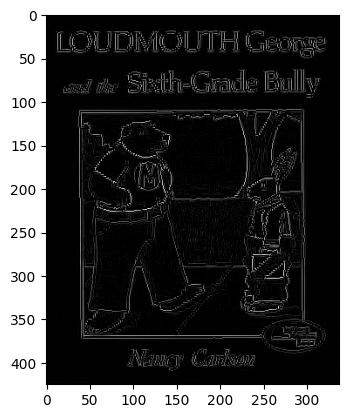

In [26]:
plt.imshow(megnitude,cmap='gray')

In [27]:
#step 5 hystersis
def hystersis(i,j):
  r,c=megnitude.shape

  if((i>=0 and i<=r-1)and (j>=0 and j<c-1)):

    #corner index case
    if((i==0 and j==0)or (i==0 and j==c-1)or (i==r-1 and j==0) or (i==r-1 and j==c-1)):
      if((i==0 and j==0)):
        region=megnitude[i:i+2,j:j+2] #  top left corner
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0
      elif((i==0 and j==c-1)):    #top right corner
        region=megnitude[i:i+2,j-1:j+1]
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0
      elif((i==r-1 and j==0)): # bottom left  corner
        region=megnitude[i-1:i+1,j:j+2]
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0
      elif((i==r-1 and j==c-1)): #bottom right corner
        region=megnitude[i-1:i+1,j-1:j+1]
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0

     # means centeral pixel
    elif((i>0 and i<r-1)and (j>0 and j<c-1)):
      region=megnitude[i-1:i+2,j-1:j+2]
      if(np.max(region)>=megnitude[i,j]):
        return np.max(region)
      else:
        return 0

    #for pixel in 1st row,last cols,1st col,last row except corner pixel
    elif((j==0 and (i!=0 and i!=r-1)) or (i==0 and(j!=0 and j!=c-1)) or (j==c-1 and (i!=0 and i!=r-1)) or (i==r-1 and(j!=0 and j!=c-1)) ):
      if((j==0 and (i!=0 and i!=r-1))):
        region=megnitude[i-1:i+2,j:j+2]  # 1st column
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0
      elif((i==0 and(j!=0 and j!=c-1))): # 1st row
        region=megnitude[i:i+2,j-1:j+2]
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0
      elif((j==c-1 and (i!=0 and i!=r-1))): # for last column
        region=megnitude[i-1:i+2,j-1:j+1]
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0
      elif((i==r-1 and(j!=0 and j!=c-1))):  # for last row
        region=megnitude[i-1:i+1,j-1:j+2]
        if(np.max(region)>=megnitude[i,j]):
          return np.max(region)
        else:
          return 0



In [28]:
# thresholding on base of strong pixel,weak pixel --> right now
def thresholding(img,high_thres,low_thres):
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      if(img[i,j]>high_thres): # strong pixel
        img[i,j]=img[i,j]
      elif(img[i,j]<high_thres and img[i,j]>=low_thres): # weak pixel , you have to perform hystersis for decision
        img[i,j]=hystersis(i,j)
      elif(img[i,j]<low_thres):
        img[i,j]=0

  return img

In [29]:
#step 4,5: double thresholding and hystersis

ratio_high=0.4
ratio_low=0.1
high_threshold=np.max(megnitude)*ratio_high
low_threshold=np.max(megnitude)*ratio_low


# function call
resultant_img=thresholding(megnitude,high_threshold,low_threshold)



In [30]:
print(low_threshold,high_threshold)

50.60355718721758 202.41422874887033


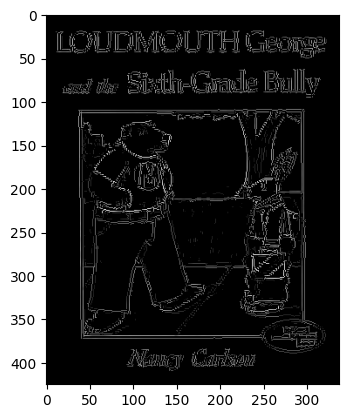

In [31]:
plt.imshow(resultant_img,cmap='gray')



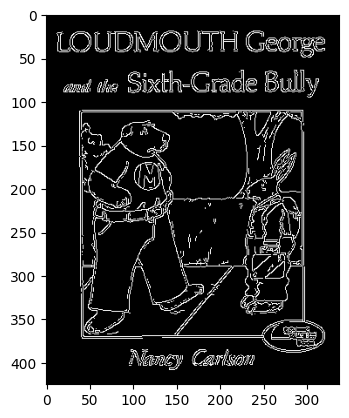

In [32]:
canny=cv.Canny(gray_img,100,200)
plt.imshow(canny,cmap='gray')